# Bayes Models: SI LSx
#### Transformation model based variational inference
#### Tabular data: SI LSx model and evaluation on one-parameter-models

In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow_probability import distributions as tfd
from sklearn import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras import initializers


from sklearn.metrics import roc_auc_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import tqdm
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass
%load_ext autoreload
%autoreload 2
from functions.vimlts import VimltsLinear
from functions.vimlts_fixBias import VimltsLinearB
from functions.sample_bernoulli_nll import sample_bernoulli_nll
from functions.scoreCI import score_ci
from functions.vimlts_fast_nullModel import VimltsLinearNull
from functions.logScore import logScore

import sys
print(sys.version)
print(tf.__version__)


2021-11-27 21:41:39.420706: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-27 21:41:40.558002: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-27 21:41:40.558496: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-27 21:41:40.620286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 21:41:40.620792: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.815GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-11-27 21:41:40.620817: I tensorflow/stream_executor/platf

3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
2.4.1


2021-11-27 21:41:40.856277: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-27 21:41:40.856793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 21:41:40.857076: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.815GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-11-27 21:41:40.857095: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic libra

In [2]:
# Load data
dat = pd.read_csv('../thesis/patientData.csv')
train_dir = "../thesis/trainRes/"

In [3]:
np.random.seed(3004)
idx = np.arange(len(dat))
np.random.shuffle(idx)

# 80% training
train_idx = idx[:int(len(dat)*0.8)] 
# 20% test
test_idx = idx[int(len(dat)*0.8):] 
# 20% of training as validation
valid_idx = train_idx[:int(len(train_idx)*0.2)] 
train_idx = train_idx[int(len(train_idx)*0.2):]
print(train_idx.shape, valid_idx.shape, test_idx.shape)

(21200,) (5300,) (6626,)


In [4]:
X_train = dat.iloc[train_idx]
X_valid= dat.iloc[valid_idx]
X_test= dat.iloc[test_idx]
print(X_train.shape, X_valid.shape, X_test.shape)
y_train = dat.iloc[train_idx]
y_train = y_train.loc[:, y_train.columns.intersection(['target'])]
y_valid= dat.iloc[valid_idx]
y_valid = y_valid.loc[:, y_train.columns.intersection(['target'])]
y_test= dat.iloc[test_idx]
y_test = y_test.loc[:, y_train.columns.intersection(['target'])]
print(y_train.shape, y_valid.shape, y_test.shape)

(21200, 9) (5300, 9) (6626, 9)
(21200, 1) (5300, 1) (6626, 1)


In [5]:
dat['age_approx'] = dat['age_approx'].fillna(dat['age_approx'].mean())
X_trainAge = dat.iloc[train_idx]
X_trainAge = X_train['age_approx']
X_validAge= dat.iloc[valid_idx]
X_validAge = X_valid['age_approx']
X_testAge= dat.iloc[test_idx]
X_testAge = X_test['age_approx']
print(X_trainAge.shape, X_validAge.shape, X_testAge.shape)

(21200,) (5300,) (6626,)


In [6]:
### standardized patients age
def standard(data):
    mean = np.mean(data)
    std = np.std(data)
    standard = (data - mean) / std
    return standard
standAge = standard(X_trainAge).ravel()
standAgeTr = pd.DataFrame({'age': standAge},columns=['age'])


standAgeValid = standard(X_validAge).ravel()
standAgeVal = pd.DataFrame({'age': standAgeValid},columns=['age'])

standAgeTest= standard(X_testAge).ravel()
standAgeTe = pd.DataFrame({'age': standAgeTest},columns=['age'])

np.std(standAgeTr), np.mean(standAgeTr)

(age    1.0
 dtype: float64,
 age    1.628009e-16
 dtype: float64)

## Functions

In [7]:
# manipulate tm-vi parameters
def softplus_inv(y):
    return np.log(np.exp(y) - 1)

# combine two components
def modelOn(X_meta, X):
    added = tf.keras.layers.Add()([X_meta.output, X.output]) 
    out = tf.math.sigmoid(added)
    model1 = keras.Model(inputs = [X_meta.input, X.input], outputs = out)
    return model1 

# Prior
prior_dist=tfd.Normal(loc=0.,scale=1.)

## One-parameter model:
### Nullmodel only intercept


In [9]:
# Prior
prior_dist=tfd.Normal(loc=0.,scale=1.)
# range of bernsteinpolynoms
theta_start = -4
theta_stop = -2
# Number of samples to approximate the expected value
num_samples=1000
train_size= standAgeTr.shape[0]
M = 50
# init params
kernel_initializers=dict(bias_init_alpha_w =initializers.Constant(1.),
                         bias_init_beta_w = initializers.Constant(0.),
                         bias_init_alpha_z = initializers.Constant(1.),
                         bias_init_beta_z = initializers.Constant(0.),
                         bias_init_thetas = [initializers.Constant(theta_start)] +
                         [initializers.Constant(softplus_inv((theta_stop-theta_start)/(M))) for i in range(M)])

# define model
x_in = Input(shape=(1,))
x_out = VimltsLinearNull(1,
                         activation=tf.keras.activations.sigmoid,
                         **kernel_initializers,
                         num_samples=num_samples,
                         size= train_size,
                         prior_dist=prior_dist) (x_in)

model_Null = Model(x_in, x_out, name="null_model")   
model_Null.summary()

Model: "null_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
vimlts_linear_null_1 (Vimlts (1000, 1, 1)              55        
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


#### Train model

In [ ]:
epochs=500
model_Null.compile(optimizer=Adam(lr=1e-4), loss=sample_bernoulli_nll, run_eagerly=False)
model_Null.fit(np.zeros(len(standAgeTr)), y_train, verbose=True)
### save model weights
#model_VIMLTS.save_weights("../thesis/models/VITM-Tab_Intercept", save_format ="tf")

#### Load weights 

In [14]:
#recreate Model
model_Null.compile(optimizer=Adam(lr=1e-4), loss=sample_bernoulli_nll, run_eagerly=False)
#load the state of the old model
model_Null.load_weights("../thesis/models/VITM-Tab_Intercept")
layer = model_Null.layers[1]
qw_Null, w_Null = layer.get_b_dist()


Two checkpoint references resolved to different objects (<functions.vimlts_fast_nullModel.VimltsLinearNull object at 0x7f7b74628760> and <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f7b74628d00>).


In [15]:
# Predictions 
y_predsA = model_Null.predict(standAgeTe,batch_size=1)
samplesAllData = y_predsA.reshape(-1, 1000)
meanpred = samplesAllData.mean(axis=1)
predictions=meanpred.reshape(6626,1)
y_predictions_2p5Tab=np.quantile(samplesAllData,0.025,axis=1)
y_predictions_97p5Tab=np.quantile(samplesAllData,0.975,axis=1)

In [16]:
# log-score
logScore(y_test,predictions)

-0.08817781024344587

In [17]:
#AUC
score, ci_lower, ci_upper, scores =score_ci(y_test, meanpred, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))

AUC=0.48, 95% CI: 0.43-0.54


### Fix intercept

In [20]:
# range of bernsteinpolynoms
theta_start = 0.4
theta_stop = 0.7
# Number of samples to approximate the expected value
num_samples=1000
train_size= standAgeTr.shape[0]

M = 50

# init params
kernel_initializers=dict(kernel_init_alpha_w =initializers.Constant(1.),               
                             kernel_init_beta_w = initializers.Constant(0.),
                             kernel_init_alpha_z = initializers.Constant(1.),
                             kernel_init_beta_z = initializers.Constant(0.),
                             kernel_init_thetas = [initializers.Constant(theta_start)] +
                             [initializers.Constant(softplus_inv((theta_stop-theta_start)/(M))) for i in range(M)]
                             )
# define model
x_in = Input(shape=(1,))
x_out = VimltsLinearB(1,
                     activation=tf.keras.activations.sigmoid,
                     **kernel_initializers,
                     num_samples=num_samples,
                     size= train_size,
                     prior_dist=prior_dist) (x_in)

model_fixI = Model(x_in, x_out, name="fix_intercept")  
model_fixI.summary()


Model: "fix_intercept"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
vimlts_linear_b_1 (VimltsLin (1000, None, 1)           56        
Total params: 56
Trainable params: 55
Non-trainable params: 1
_________________________________________________________________


#### Train model

In [ ]:
epochs = 5000   ##to have the acurate posterior 
model_fixI.compile(optimizer=Adam(lr=1e-4), loss=sample_bernoulli_nll, run_eagerly=False)
model_fixI.fit(standAgeTr, y_train,batch_size=256, epochs=epochs, verbose = True)

In [23]:
### save model weights
#model.save_weights("../thesis/models/VITM-FixIntercept-Tabular", save_format ="tf")

#### Load weights

In [27]:
model_fixI.compile(optimizer=Adam(lr=1e-4), loss=sample_bernoulli_nll, run_eagerly=False)
## load the state of the old model
model_fixI.load_weights("../thesis/models/VITM-FixIntercept-Tabular")
## posterior distribution
layer = model_fixI.layers[1]
qw_fixI, w_fixI = layer.get_w_dist()


Two checkpoint references resolved to different objects (<functions.vimlts_fixBias.VimltsLinearB object at 0x7fa3a95706a0> and <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fa3a947aaf0>).


## M1: SI LSx with slope and intercept
### Meanfield-TM-VI

In [43]:
M=50
theta_start = -1
theta_stop = 1
delta_theta = softplus_inv((theta_stop-theta_start)/(M))
theta_startB = -5
theta_stopB = 5

vimlts_initializers=dict(kernel_init_alpha_w = initializers.Constant(1.),
                             kernel_init_beta_w = initializers.Constant(0.),
                             kernel_init_alpha_z = initializers.Constant(1.),
                             kernel_init_beta_z = initializers.Constant(0.),
                             kernel_init_thetas = [initializers.Constant(theta_start)] + 
                             [initializers.Constant(delta_theta) for _ in range(M)],
                             bias_init_alpha_w = initializers.Constant(1.),
                             bias_init_beta_w = initializers.Constant(0.),
                             bias_init_alpha_z = initializers.Constant(1.),
                             bias_init_beta_z = initializers.Constant(0.),
                             bias_init_thetas = [initializers.Constant(theta_startB)] +
                             [initializers.Constant(softplus_inv((theta_stopB-theta_startB)/(M))) for i in range(M)])

In [44]:
x_in = Input(shape=(1,))

x_arch = VimltsLinear(units=1,
                      activation=tf.keras.activations.sigmoid,
                      num_samples = 1000,
                      size= 21200,
                      **vimlts_initializers,
                      prior_dist=prior_dist)(x_in)

model_SILSx = Model(x_in, x_arch, name="SI_LSx")
model_SILSx.summary()

Model: "SI_LSx"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
vimlts_linear_2 (VimltsLinea (1000, None, 1)           110       
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


#### Train model

In [ ]:
### Train
epochs = 500
batch_size= 256
model_SILSx.compile(optimizer=Adam(lr=1e-4), loss=sample_bernoulli_nll, run_eagerly=False)
model_SILSx.fit(standAgeTr, y_train,batch_size=batch_size,validation_data =(standAgeVal,y_valid), epochs=epochs, verbose=True)

In [19]:
# save results
#dat = pd.DataFrame({'train_loss': model_SILSx.history.history['loss'], 
                       # 'val_loss': model_SILSx.history.history['val_loss']})
#dat.to_csv('../thesis/RunsTMVI_SILS/history.csv', index=False)
### save model weights
#model_SILSx.save_weights("../thesis/models/VITM-Tabular", save_format ="tf")

#### Load weights

In [45]:
### recreate Model
model_SILSx.compile(optimizer=Adam(lr=1e-4),metrics=[sample_bernoulli_nll], loss=sample_bernoulli_nll, run_eagerly=False)
### load the state of the old model
model_SILSx.load_weights("../thesis/models/VITM-Tabular")

## posterior distribution of slope
layer_s = model_SILSx.layers[1]
qw_LS, w_LS = layer_s.get_w_dist()
## sample direct 
layer_w = model_SILSx.layers[1]
sample_w = layer_w.samplew()

## posterior distribution of bias term
layer_b = model_SILSx.layers[1]
qb_SI, b_SI = layer_b.get_b_dist()

## Loss

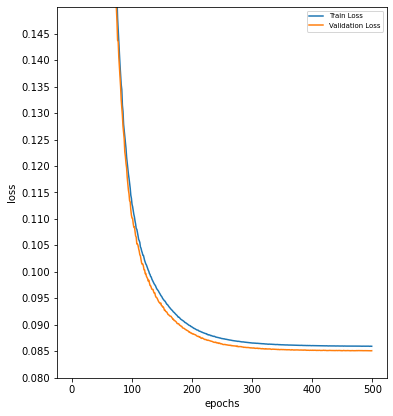

In [35]:
loss_0 = pd.read_csv('../thesis/RunsTMVI_SILS/history.csv')
plt.figure(figsize=(13,15))
plt.subplot(221)
plt.plot(loss_0['train_loss'],label="Train Loss")
plt.plot(loss_0['val_loss'], label="Validation Loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0.08,0.15)
plt.yticks(np.arange(0.08, 0.15, 0.005))
plt.legend(fontsize='x-small')

#plt.savefig("./plots/uncertainty/LOSS_TMVI_SILSx.pdf")

## Performance

In [63]:
# Predictions 
y_predsA = model_SILSx.predict(standAgeTe,batch_size=1)
samplesAllData = y_predsA.reshape(-1, 1000)
meanpred = samplesAllData.mean(axis=1)
predictions=meanpred.reshape(6626,1)
y_predictions_2p5Tab=np.quantile(samplesAllData,0.025,axis=1)
y_predictions_97p5Tab=np.quantile(samplesAllData,0.975,axis=1)

2021-11-19 09:12:16.677617: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-19 09:12:16.696294: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


In [64]:
# log-score
logScore(y_test,predictions)

-0.08502441274704692

In [65]:
#AUC
score, ci_lower, ci_upper, scores =score_ci(y_test, meanpred, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))

AUC=0.66, 95% CI: 0.61-0.71


## Model with two components to have linear outcomes 
### Logit model 

In [98]:
M=50

theta_start = -1
theta_stop = 1


theta_startB = -5
theta_stopB = 5

vimlts_initializersLinearShift=dict(kernel_init_alpha_w = initializers.Constant(1.),
                             kernel_init_beta_w = initializers.Constant(0.),
                             kernel_init_alpha_z = initializers.Constant(1.),
                             kernel_init_beta_z = initializers.Constant(0.),
                             kernel_init_thetas = [initializers.Constant(theta_start)] +
                              [initializers.Constant(softplus_inv((theta_stop-theta_start)/(M))) for i in range(M)])

vimlts_initializersBias=dict(kernel_init_alpha_w = initializers.Constant(1.),
                             kernel_init_beta_w = initializers.Constant(0.),
                             kernel_init_alpha_z = initializers.Constant(1.),
                             kernel_init_beta_z = initializers.Constant(0.),
                             kernel_init_thetas = [initializers.Constant(theta_startB)] +
                              [initializers.Constant(softplus_inv((theta_stopB-theta_startB)/(M))) for i in range(M)])

prior_dist=tfd.Normal(loc=0.,scale=1.)


In [99]:
##Simple Intercept
# bias 
in_ = keras.Input(shape = (1, ))
out_ = VimltsLinear(units=1,
                      activation=tf.keras.activations.linear,
                      num_samples=1000,
                      size = 21200,
                      **vimlts_initializersBias,
                      prior_dist=prior_dist)(in_)
SI_NN = keras.Model(inputs = in_, outputs = out_, name="SI")
SI_NN.summary()

Model: "SI"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
vimlts_linear_10 (VimltsLine (1000, None, 1)           55        
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


In [100]:
##### Tabular Data 

### no bias 

inCov = keras.Input(shape = standAgeTr.shape[1:])
outCov = VimltsLinear(units=1,
                      activation=tf.keras.activations.linear,
                      num_samples=1000,
                      size = 21200,
                      **vimlts_initializersLinearShift,
                      prior_dist=prior_dist)(inCov)

LS_NN = keras.Model(inputs = inCov, outputs = outCov,name="LSx" )
LS_NN.summary()

Model: "LSx"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
vimlts_linear_11 (VimltsLine (1000, None, 1)           55        
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


In [101]:
# define model
SI_LSx2 = modelOn(SI_NN,LS_NN)
SI_LSx2.compile(loss=sample_bernoulli_nll, optimizer=Adam(1e-4),run_eagerly=False)
SI_LSx2.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
vimlts_linear_10 (VimltsLinear) (1000, None, 1)      55          input_12[0][0]                   
__________________________________________________________________________________________________
vimlts_linear_11 (VimltsLinear) (1000, None, 1)      55          input_13[0][0]                   
____________________________________________________________________________________________

#### Train model

In [ ]:
results = SI_LSx2.fit(x=[np.ones((y_train.shape[0], 1)), standAge],
                        y = y_train,
                        validation_data = ([np.ones((y_valid.shape[0], 1)), standAgeValid], y_valid),
                        batch_size=256,
                        epochs = 3000,
                        verbose= True,
                       )    

In [ ]:
### save model weights
#SI_LSx2.save_weights("../thesis/models/VITM-TabularComponents", save_format ="tf")
## save linear shift weights
#LS_NN.save_weights("../thesis/models/VITM-TabularComponentsTab", save_format ="tf")

#### Load model

In [102]:
SI_LSx2.compile(optimizer=Adam(lr=1e-4), loss=sample_bernoulli_nll, run_eagerly=False)

### load the state of the old model
SI_LSx2.load_weights("../thesis/models/VITM-TabularComponents")
### load LS NN
LS_NN.load_weights("../thesis/models/VITM-TabularComponentsTab")

### posterior distribution of slope
layer = LS_NN.layers[1]
qw_LS2, w_LS2 = layer.get_w_dist()

#### Check performance if it is the same as previous model

In [84]:
xtest= [np.ones((y_test.shape[0], 1)), standAgeTe]
y_predsA = SI_LSx2.predict(xtest,batch_size=1)
samplesAllData = y_predsA.reshape(-1, 1000)
meanpred = samplesAllData.mean(axis=1)

predictions=meanpred.reshape(6626,1)

y_predictions_2p5Tab=np.quantile(samplesAllData,0.025,axis=1)
y_predictions_97p5Tab=np.quantile(samplesAllData,0.975,axis=1)

In [85]:
# logscore
logScore(y_test,predictions)

-0.08497958513781588

In [86]:
###AUC
score, ci_lower, ci_upper, scores =score_ci(y_test, meanpred, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))

AUC=0.66, 95% CI: 0.61-0.71


## Posterior predictive distribution
#### 1. Outcome of logit model 
#### 2. Probabilites after sigmoid

#### Data preparation

In [110]:
# OOD for standardized age 
oodTabNegative = np.arange(-10, -4, 0.1)
oodTabPositive = np.arange(4, 10, 0.1)
oodTab = [*oodTabNegative, *oodTabPositive]
oods = pd.DataFrame(oodTab)

sortX = standAgeTe[0:120].sort_values("age", ascending = True)
data = []

# extreme value -10,10

data.insert(0, {'age': -10})
data.insert(0, {'age': 10})
negative=pd.DataFrame(oodTabNegative)
r=oods.rename(columns={0: 'age'})
s =pd.concat([pd.DataFrame(data), sortX,r], ignore_index=False) # does not save changes to the original dataframe
sortAgeTest = s.sort_values("age", ascending = True)


# PPD 

In [111]:
preds_list = [] 
xtestOO= [np.ones((sortAgeTest.shape[0], 1)), sortAgeTest]


# Iterate over number of predictions
for i in tqdm.tqdm(range(1000)):
    y_pred_VIMLTS = SI_LSx2.predict(xtestOO,batch_size=242)[0]
    preds_list.append(y_pred_VIMLTS)

y_preds = np.concatenate(preds_list, axis=1)
y_predictions_mean=np.mean(y_preds,axis=1)
y_predictions_2p5=np.quantile(y_preds,0.025,axis=1)
y_predictions_97p5=np.quantile(y_preds,0.975,axis=1)

100%|██████████| 1000/1000 [00:23<00:00, 42.95it/s]


In [112]:
##logit BEHALTEN
# VIMLTS
preds_listOdds = []
xtestOO= [np.ones((sortAgeTest.shape[0], 1)), sortAgeTest]
intermediate_layer_model = Model(inputs=SI_LSx2.input, outputs=SI_LSx2.layers[4].output)

# Iterate over number of predictions
for i in tqdm.tqdm(range(1000)):
    y_pred_VIMLTSOdds = intermediate_layer_model.predict(xtestOO,batch_size=242)[0]
    preds_listOdds.append(y_pred_VIMLTSOdds)

y_predsOdds = np.concatenate(preds_listOdds, axis=1)
y_predictionsOdds_mean=np.mean(y_predsOdds,axis=1)
y_predictions_2p5Odds=np.quantile(y_predsOdds,0.025,axis=1)
y_predictions_97p5Odds=np.quantile(y_predsOdds,0.975,axis=1)

100%|██████████| 1000/1000 [00:23<00:00, 43.01it/s]


#### Plot Oucome distirbution and PPD

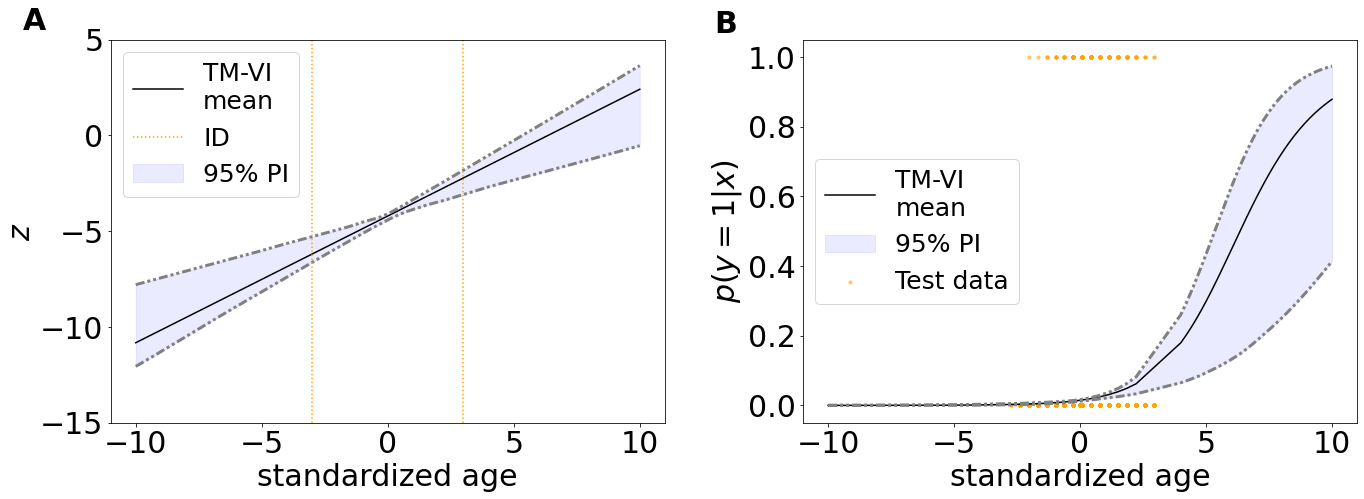

In [113]:
fig = plt.figure(figsize=(20,8))

plt.rcParams.update(({'font.size': 30}))
fig.add_subplot(121)
plt.fill_between(sortAgeTest.values.reshape(-1),y_predictions_97p5Odds,y_predictions_2p5Odds, 
                color='blue', alpha=0.08, label=(r"95% PI"))
plt.plot(sortAgeTest.values.reshape(-1),y_predictionsOdds_mean, color='black' ,label=("TM-VI \nmean"))

plt.plot(sortAgeTest.values.reshape(-1),y_predictions_2p5Odds, color='grey',linewidth=3,linestyle=(0, (3, 1, 1, 1, 1, 1)))
plt.plot(sortAgeTest.values.reshape(-1),y_predictions_97p5Odds, color='grey',linewidth=3,linestyle=(0, (3, 1, 1, 1, 1, 1)))
plt.text(-14.5, 5.5,"A", 
            size=30, weight='bold')
plt.axvline(-3, 0, 1, label='ID',linestyle="dotted",color="orange")
plt.axvline(3, 0, 1,linestyle="dotted",color="orange")

plt.legend(fontsize=25)
plt.xlabel("standardized age")
plt.ylabel("$z$")
plt.yticks(np.arange(-15, 10, step=5))
plt.xticks(np.arange(-10, 15, step=5))

fig.add_subplot(122)
plt.fill_between(sortAgeTest.values.reshape(-1),y_predictions_97p5,y_predictions_2p5, 
                color='blue', alpha=0.08, label=(r"95% PI"))
plt.plot(sortAgeTest.values.reshape(-1),y_predictions_mean, color='black' ,label=("TM-VI \nmean"))
plt.plot(sortAgeTest.values.reshape(-1),y_predictions_2p5, color='grey',linewidth=3,linestyle=(0, (3, 1, 1, 1, 1, 1)))
plt.plot(sortAgeTest.values.reshape(-1),y_predictions_97p5, color='grey',linewidth=3,linestyle=(0, (3, 1, 1, 1, 1, 1)))
plt.scatter(standAgeTest,y_test, color='orange', s=10,alpha=0.5,label="Test data")
plt.text(-14.5, 1.07,"B", 
            size=30, weight='bold')
plt.legend(loc="center left",fontsize=25)
plt.xlabel("standardized age")
plt.ylabel("$p (y=1|x)$")
plt.yticks(np.arange(0., 1.2, step=0.2))
plt.xticks(np.arange(-10, 15, step=5))

fig.tight_layout(pad=1.5)
#plt.savefig("./plots/uncertainty/TabularPPD.pdf")

In [2]:
%reload_ext version_information
%version_information tensorflow,numpy, pandas, matplotlib, seaborn

Software versions
Python 3.9.7 64bit [GCC 7.5.0]
IPython 7.27.0
OS Linux 5.8.0 63 generic x86_64 with glibc2.32
tensorflow 2.4.1
numpy 1.21.2
pandas 1.3.3
matplotlib 3.4.3
seaborn 0.11.2
Wed Nov 24 11:59:12 2021 CET